In [1]:
import numpy as np
import scipy.stats as ss
import numpy.random as npr
import pandas as pd

import seaborn as sns
import pylab as pl
import collections

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def generate_user(n_classes=2, n_components=2, n_interests=2, p_c=[0.3, 0.7], p_m=[[0.99, 0.01], [0.5, 0.5]], mu=[35.0, 20.0], std=10.0, lbd=[2.0, 3.0], p_i=[[0.2, 0.3], [0.6, 0.9]]):
    assert len(p_c) == n_classes
    assert np.array(p_m).shape == (n_classes, n_components)
    assert np.array(p_i).shape == (n_classes, n_interests)
    
    result = {}
    
    klass = np.arange(n_classes)[npr.multinomial(1, p_c).astype(bool)][0]
    # print "Sampled class: %s" % klass
    result["klass"] = klass    
    
    for j in xrange(n_interests):
        result["int_%d" % j] = int(npr.random() < p_i[klass][j])
    
    p_mix = p_m[klass]
    # print "P_mixture: %s" % p_mix    
    
    n_presents = npr.zipf(2.4, 1)
    for j in xrange(n_presents):   
        component = np.arange(n_components)[npr.multinomial(1, p_mix).astype(bool)][0]
        # print "Sampled_component: %s" % component    

        if component == 0:
            # Exponential
            p = np.ceil(npr.exponential(1.0/lbd[klass]))
        elif component == 1:
            # Normal
            p = int(npr.normal(mu[klass], std, 1)[0] + 1)
        # print "Sampled price %s" % p        
        
        if p > 0 and p <= 100:
            result[p] = result.get(p, 0) + 1
    
    if sum([result.get(n, 0) for n in xrange(1, 101)]) > 0:
        return result
    else:
        return generate_user(n_classes, n_components, n_interests, p_c, p_m, mu, std, lbd, p_i)    

In [52]:
df = pd.DataFrame([generate_user() for i in xrange(10000)], columns=["klass", "int_0", "int_1"] + range(1, 101))
df.fillna(0, inplace=True)

df.head()

,klass,int_0,int_1,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


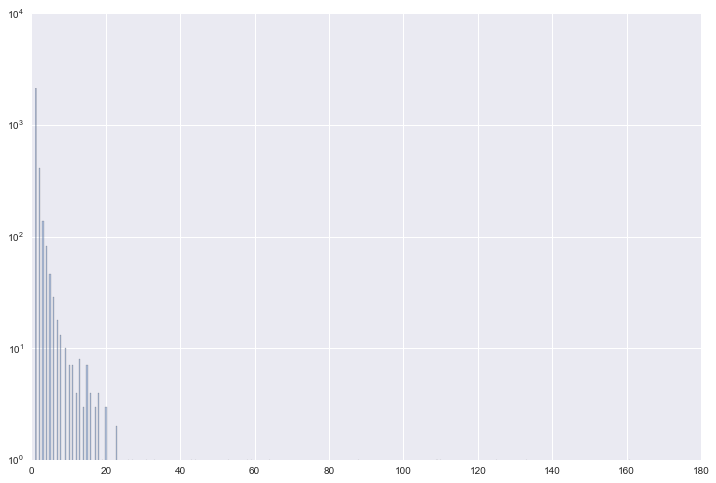

In [53]:
pl.figure(figsize=(12, 8))
sns.distplot(df[df["klass"] == 0][range(1, 101)].sum(axis=1), bins=500, rug=False, kde=False)
pl.gca().set_yscale('log')
pl.show()

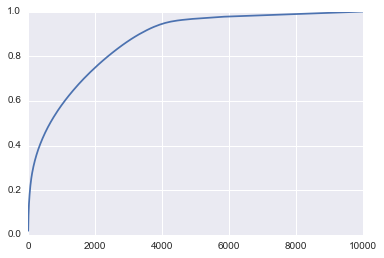

,klass,int_0,int_1,1,2,3,4,5,6,7,...,91,92,93,94,95,96,97,98,99,100
4855,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9269,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3939,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3597,1,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
spent = pd.Series(df[range(1, 101)].values.dot(range(1, 101)), index=df.index)

pl.plot(arange(df.shape[0]), np.cumsum(spent.sort_values(ascending=False)) / spent.sum())
pl.show()

# Take users that generate 80% of income and then sample from them
dfs = df.ix[spent.sort_values(ascending=False).index[:df.shape[0]/3]].sample(1000)

dfs.head()

In [55]:
dfs.head().sum(axis=1)

4855    5
9269    3
3939    4
3597    9
26      4
dtype: float64

In [56]:
def visualize_dist(dfx, N=None, M=None, color='r'):
    if N is None:
        N = np.ceil(np.sqrt(dfx.shape))
        M = np.ceil(np.sqrt(dfx.shape))

    fig = pl.figure(figsize=(M*3, N*3))

    for i, (uid, row) in enumerate(dfx.sample(N*M).iterrows()):
        ax = pl.subplot(N, M, i + 1)
#         print row.index, row.values
        ax.bar(row.index + 0.5, row.values, color=color, alpha=0.7)
        pl.title(uid)
        pl.xticks(range(0, 101, 20))
        pl.xlim(0, 101)
        pl.ylim(0, 100)
    
    fig.tight_layout()
    pl.show()

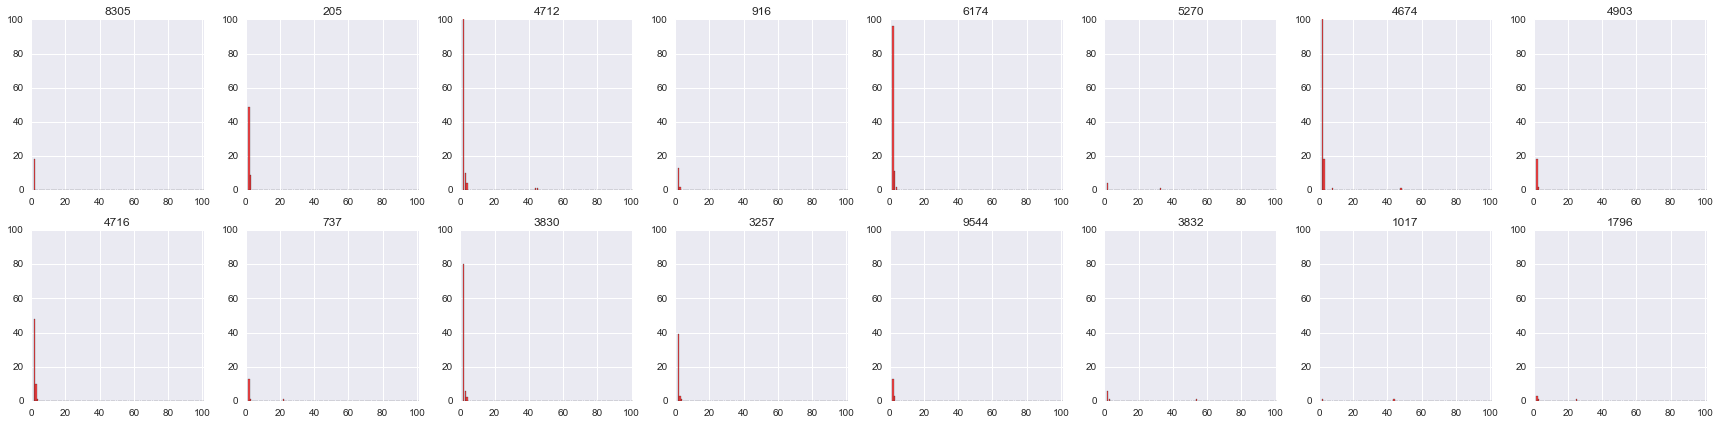

In [57]:
visualize_dist(dfs[dfs["klass"] == 0][range(1, 101)], 2, 8)

## Bayesian

### PyMC

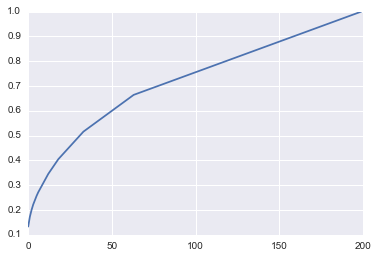

,klass,int_0,int_1,int_2,int_3,int_4,int_5,int_6,1,2,...,91,92,93,94,95,96,97,98,99,100
152,0,0,0,0,0,0,1,0,35,9,...,0,0,0,0,0,0,0,0,0,0
124,1,1,0,0,1,0,0,1,9,0,...,0,0,0,0,0,0,0,0,0,0
199,2,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
56,1,1,0,0,1,0,0,1,5,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,1,1,0,1,0,6,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
import pymc as pm

n_users = 20

n_classes = 3
n_interests = 7

p_c=[0.3, 0.2, 0.5]

p_m=[[0.8, 0.2], [0.5, 0.5], [0.1, 0.9]]
mu=[35.0, 20.0, 50.0]
std=10.0
lbd=[2.0, 3.0, 1.0]

p_i=[[0.2, 0.1, 0.7, 0.5, 0.1, 0.7, 0.5], [0.6, 0.1, 0.3, 0.9, 0.1, 0.3, 0.9], [0.9, 0.8, 0.5, 0.1, 0.8, 0.5, 0.1]]

df = pd.DataFrame([generate_user(n_classes, 2, n_interests, p_c, p_m, mu, std, lbd, p_i) for i in xrange(n_users * 10)], columns=["klass"] + ["int_%d" % i for i in xrange(n_interests)] + range(1, 101))
df.fillna(0, inplace=True)

spent = pd.Series(df[range(1, 101)].sum(axis=1), index=df.index)

pl.plot(arange(df.shape[0]), np.cumsum(spent.sort_values(ascending=False)) / spent.sum())
pl.show()

# Take users that generate 80% of income and then sample from them
df = df.ix[spent.sort_values(ascending=False).index[:n_users]]

df.head()

In [4]:
df = pd.read_csv('/Users/anokhin/Desktop/train_set.csv').set_index('uid').sample(n_users)
df["klass"] = 0
df.head()

,int_0,int_1,int_2,int_3,int_4,int_5,int_6,1,2,3,...,92,93,94,95,96,97,98,99,100,klass
uid,,,,,,,,,,,,,,,,,,,,,
N:557360950981,0,0,0,0,1,1,0,61,4,0,...,0,0,0,0,0,0,0,0,0,0
N:342768086326,1,0,0,1,0,0,0,17,9,1,...,0,0,0,0,0,0,0,0,0,0
N:481104390818,0,0,0,0,0,0,0,18,0,0,...,0,0,0,0,0,0,0,0,0,0
N:574254196533,1,0,1,0,1,0,0,9,4,0,...,0,0,0,0,0,0,0,0,0,0
N:444903338346,0,0,0,0,0,0,1,23,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
print df.groupby(["klass"]).size()
n_classes = 4
# x = np.linspace(-10, 10, 1000)
# y = ss.expon.pdf(x, 0, 2./3)
# plot(x, y)

klass
0    10
1     5
2     5
dtype: int64


In [44]:
def interest_selector(klass, interest_priors):
    return interest_priors[klass]

def mixture_selector(klass, mixture_priors):
    return mixture_priors[klass]

def mu_selector(klass, mu_priors):
    return mu_priors[klass]

def tau(sigma):
    return 1 / sigma ** 2

def sigma_selector(klass, sigma_priors):
    return sigma_priors[klass]

def beta_selector(klass, beta_priors):
    return beta_priors[klass]

def price_rand(mixture_prior, mu_prior, sigma_prior, beta_prior):
    if npr.random() < mixture_prior:
        return npr.exponential(1.0 / beta_prior)
    else:
        return npr.normal(mu_prior, sigma_prior)       

def price_logp(value, mixture_prior, mu_prior, sigma_prior, beta_prior):    
    if isinstance(value, np.ndarray) and value.shape == ():        
        values = [value.tolist()]
    elif isinstance(value, collections.Iterable):
        values = value
    else:
        values = [value]      
        
    ll = 0
    for v in values:        
        ll += np.log(mixture_prior * ss.expon.pdf(v, 0, 1.0 / beta_prior) + (1 - mixture_prior) * ss.norm.pdf(v, mu_prior, sigma_prior))        
    return ll

def klass_prior_potential_logp(klass_prior):    
    if np.min(klass_prior) < 0.05:
        return -np.inf
    else:
        return 0

def model_definition(n_classes, n_interests, n_users):
    # Class prior
    inc_klass_prior = pm.Dirichlet("inc_klass_prior", theta=np.ones(n_classes, dtype=float), )
    klass_prior = pm.CompletedDirichlet("klass_prior", inc_klass_prior)    
    klass_prior_potential = pm.Potential(
        logp=klass_prior_potential_logp,
        name='klass_prior_potential',
        parents={'klass_prior': klass_prior},
        doc='A potential to limit class prior from vanishing',
        verbose=0,
        cache_depth=2
    )
    
    # Priors for interests
    interests_priors = np.empty((n_interests, n_classes), dtype=object)
    for j in xrange(n_interests):
        for k in xrange(n_classes):        
            interests_priors[j, k] = pm.Uniform("interest_prior_%d_%d" % (j, k), 0, 1)
            
    # Priors for mixture probs
    mixture_priors = np.empty(n_classes, dtype=object)
    mu_priors = np.empty(n_classes, dtype=object)
    sigma_priors = np.empty(n_classes, dtype=object)
    beta_priors = np.empty(n_classes, dtype=object)
    for k in xrange(n_classes):
        mixture_priors[k] = pm.Uniform("mixture_prior_%d" % k, 0, 1)
        mu_priors[k] = pm.Uniform("mu_prior_%d" % k, 5, 100)
        sigma_priors[k] = pm.Uniform("sigma_prior_%d" % k, 5, 50)
        beta_priors[k] = pm.Uniform("beta_prior_%d" % k, 0.01, 5)

    # For each user generate class
    klasses = np.empty(n_users, dtype=object)
    # For each user generate 0-1 interests
    interests = np.empty((n_users, n_interests), dtype=object)
    interest_selectors = np.empty((n_users, n_interests), dtype=object)
    # For each user generate price
    mixtures = np.empty(n_users, dtype=object)
    mus = np.empty(n_users, dtype=object)    
    sigmas = np.empty(n_users, dtype=object)
    betas = np.empty(n_users, dtype=object)
    prices = np.empty(n_users, dtype=object)
    
    for i in xrange(n_users):        
        klass_value = int(df.iloc[i]["klass"])
        klasses[i] = pm.Categorical("klass_%d" % i, klass_prior) # , value=klass_value, observed=True)
        
        # Generate interests
        for j in xrange(n_interests):            
            interest_selectors[i, j] = pm.Deterministic(
                eval=interest_selector, 
                name='is_%d_%d' % (i, j), 
                doc="Assigns interest probability using current user's class", 
                parents={'klass': klasses[i], 'interest_priors': interests_priors[j, :]},
                verbose=0, dtype=float, plot=True
            )
            interests[i, j] = pm.Bernoulli("interest_%d_%d" % (i, j), interest_selectors[i, j], value=df.iloc[i]["int_%d" % j] > 0, observed=True)
            
        # Generate presents
        mixtures[i] = pm.Deterministic(
            eval=mixture_selector, 
            name='mix_s_%d' % i, 
            doc="Assigns mixture probability using current user's class", 
            parents={'klass': klasses[i], 'mixture_priors': mixture_priors},
            verbose=0, dtype=float, plot=True
        )
        
        mus[i] = pm.Deterministic(
            eval=mu_selector, 
            name='mu_s_%d' % i, 
            doc="Assigns normal center probability using current user's class", 
            parents={'klass': klasses[i], 'mu_priors': mu_priors},
            verbose=0, dtype=float, plot=True
        )
        
        sigmas[i] = pm.Deterministic(
            eval=sigma_selector, 
            name='sigma_s_%d' % i,
            doc="Assigns normal precision probability using current user's class", 
            parents={'klass': klasses[i], 'sigma_priors': sigma_priors},
            verbose=0, dtype=float, plot=True
        )
        
        betas[i] = pm.Deterministic(
            eval=beta_selector, 
            name='b_s_%d' % i, 
            doc="Assigns exponential precision probability using current user's class", 
            parents={'klass': klasses[i], 'beta_priors': beta_priors},
            verbose=0, dtype=float, plot=True
        )
        
        price_values = []
        for p in xrange(1, 101):
            price_values.extend([p] * df.iloc[i][p])
        
        prices[i] = pm.Stochastic(
            logp=price_logp,
            doc='The price of a gift for the user',
            name='price_%d' % i,
            parents = {'mixture_prior': mixtures[i], 'mu_prior': mus[i], 'sigma_prior': sigmas[i], 'beta_prior': betas[i]},
            random = price_rand,               
            dtype=float,
            plot=True,
            value=price_values,
            observed=True
        )
        
    return locals()

mcmc = pm.MCMC(model_definition(n_classes, n_interests, n_users), db='pickle', dbname='ok.pickle')

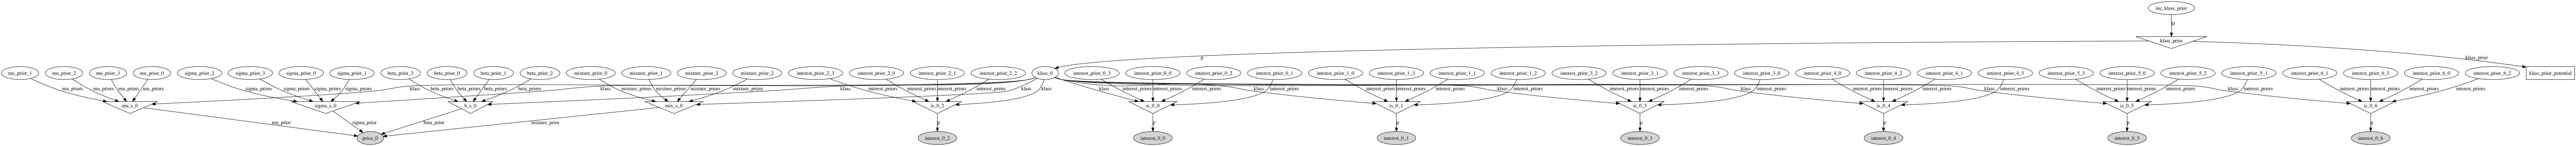

In [45]:
from IPython.display import Image
# gr = pm.graph.graph(mcmc)
# gr.write_png('/Users/anokhin/Desktop/model.png')
Image(filename='/Users/anokhin/Desktop/model.png')

In [46]:
mcmc.sample(3000, burn=0)
mcmc.db.close()

 [-----------------100%-----------------] 3000 of 3000 complete in 1427.4 sec

In [47]:
mcmc = pm.database.pickle.load('ok.pickle')

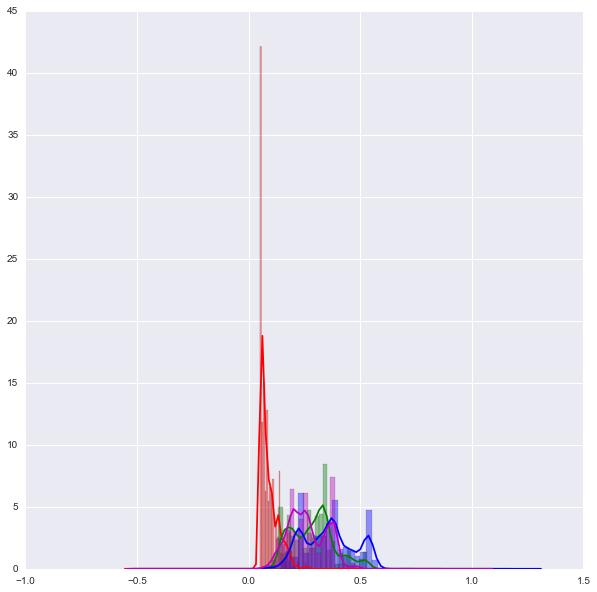

array([ 0.08806175,  0.2895207 ,  0.3584633 ,  0.26395425])

In [48]:
klass_prior_trace = mcmc.trace("klass_prior")[:].reshape(-1, n_classes)

# for pretty colors later in the book.
colors = ['r', 'g', 'b', 'm', 'y', 'c', 'k']

pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    sns.distplot(klass_prior_trace[:, k], label="class %d" % k, color=colors[k])

# pl.ylim(0, 50)
pl.show()

klass_prior_trace.mean(axis=0)

c=0, i=0 0.483236261149
c=1, i=0 0.687907182953
c=2, i=0 0.20914653777
c=3, i=0 0.832934583115
c=0, i=1 0.49960477285
c=1, i=1 0.182416911907
c=2, i=1 0.140132867494
c=3, i=1 0.835416816553
c=0, i=2 0.493971493365
c=1, i=2 0.392453454286
c=2, i=2 0.541126185511
c=3, i=2 0.136563847303
c=0, i=3 0.527371038461
c=1, i=3 0.741499522961
c=2, i=3 0.457716693549
c=3, i=3 0.142223953139
c=0, i=4 0.46384522884
c=1, i=4 0.124510781418
c=2, i=4 0.108662182772
c=3, i=4 0.556048581436
c=0, i=5 0.476554196722
c=1, i=5 0.261071322647
c=2, i=5 0.845639233667
c=3, i=5 0.592307045534
c=0, i=6 0.538063599715
c=1, i=6 0.881194116095
c=2, i=6 0.310168996791
c=3, i=6 0.142068574967


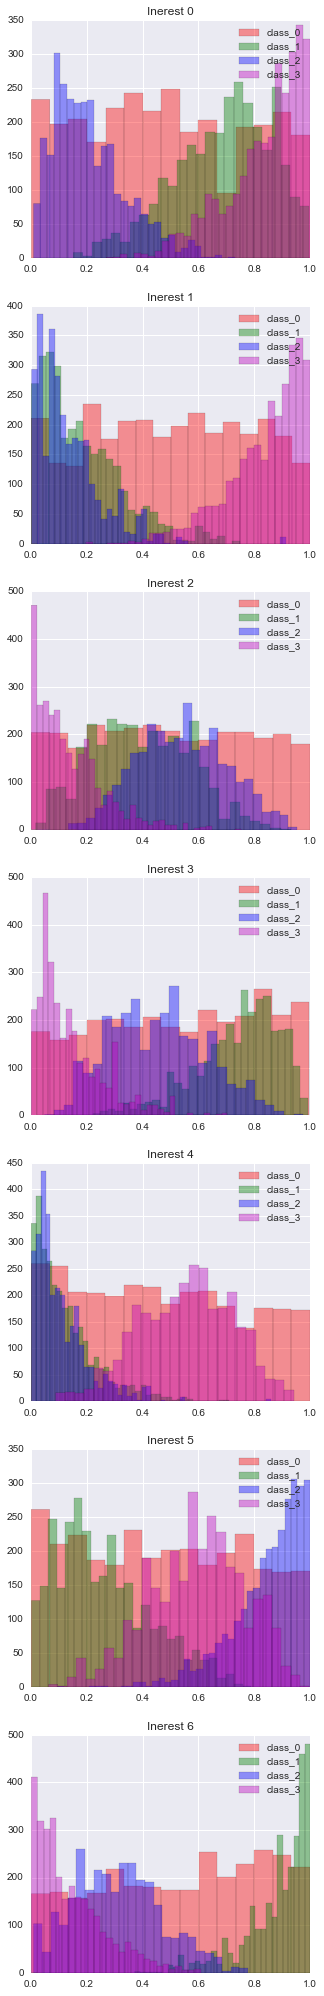

In [49]:
colors = ['r', 'g', 'b', 'm', 'y', 'c', 'k']

pl.figure(figsize=(5, n_interests * 5))
for i in xrange(n_interests):
    pl.subplot(n_interests, 1, i + 1)
    for k in xrange(n_classes):
        trace = mcmc.trace("interest_prior_%d_%d" % (i, k))[:]        
        sns.distplot(trace, label="class_%d" % k, color=colors[k], kde=False)
        print "c=%d, i=%d" % (k, i), trace.mean()
        pl.legend()
        pl.title("Inerest %d" % i)
pl.show()

0.552000782423
0.579081877867
0.764297963579
0.196385125318


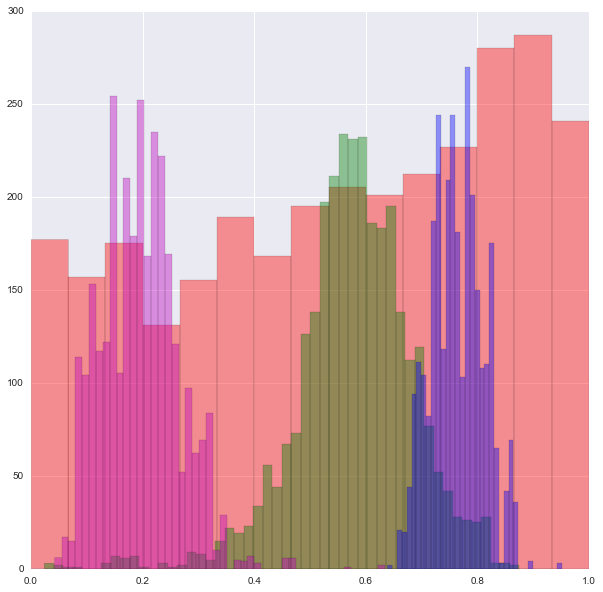

In [50]:
pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    mixture_prior_trace = mcmc.trace("mixture_prior_%d" % k)[:]
    sns.distplot(mixture_prior_trace, label="class %d" % k, color=colors[k], kde=False)
    print mixture_prior_trace.mean()

# pl.ylim(0, 50)
pl.show()

50.2724773782
19.7639091383
37.2707858918
52.9748000855


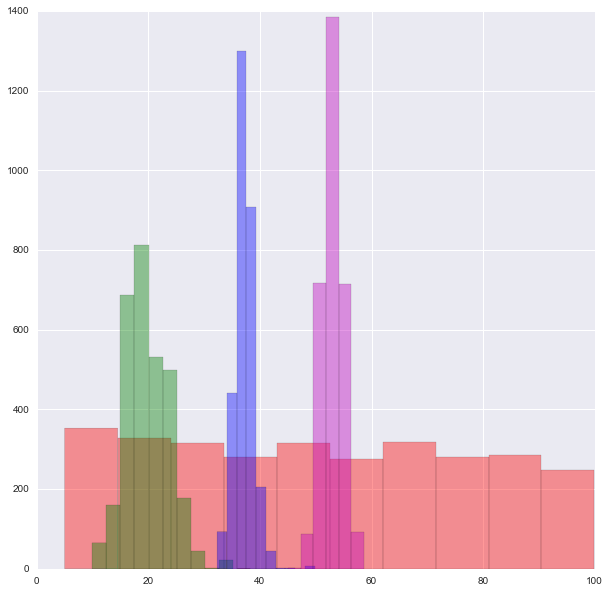

In [51]:
pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    mu_prior_trace = mcmc.trace("mu_prior_%d" % k)[:]
    sns.distplot(mu_prior_trace, label="class %d" % k, color=colors[k], kde=False, bins=10)
    print mu_prior_trace.mean()

# pl.ylim(0, 50)
pl.show()

2.09487115085
0.735284882629
0.859697475039
0.697048940573


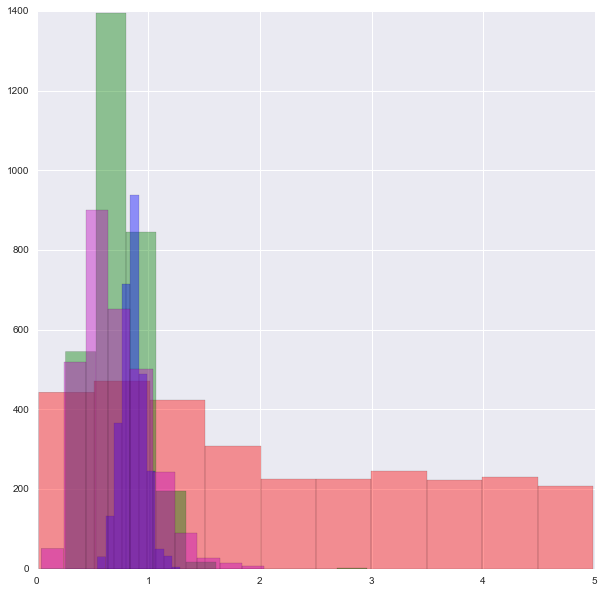

In [52]:
pl.figure(figsize=(10, 10))

for k in xrange(n_classes):
    beta_prior_trace = mcmc.trace("beta_prior_%d" % k)[:]
    sns.distplot(beta_prior_trace, label="class %d" % k, color=colors[k], kde=False, bins=10)
    print beta_prior_trace.mean()

# pl.ylim(0, 50)
pl.show()

Plotting sigma_prior_3


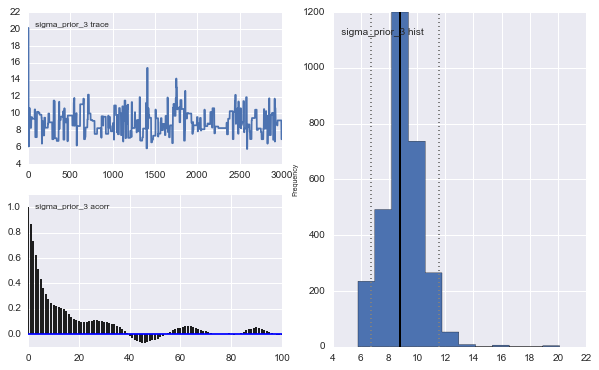

In [53]:
from pymc.Matplot import plot as mcplot

mcplot(mcmc.trace("sigma_prior_3"))

## Viz

In [11]:
import pymc as pm
from pymc.Matplot import plot as mcplot

n_users = 1000
n_classes = 4
n_interests = 7

interests = ["male", "young", "old", "rich", "edu", "family", "married"]

In [17]:
mcmc = pm.database.pickle.load('/Users/anokhin/Desktop/ok_1000_4_2.pickle')

Cluster 0, mean 0.82
Cluster 1, mean 0.07
Cluster 2, mean 0.06
Cluster 3, mean 0.06


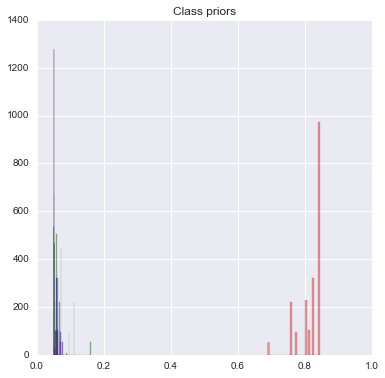

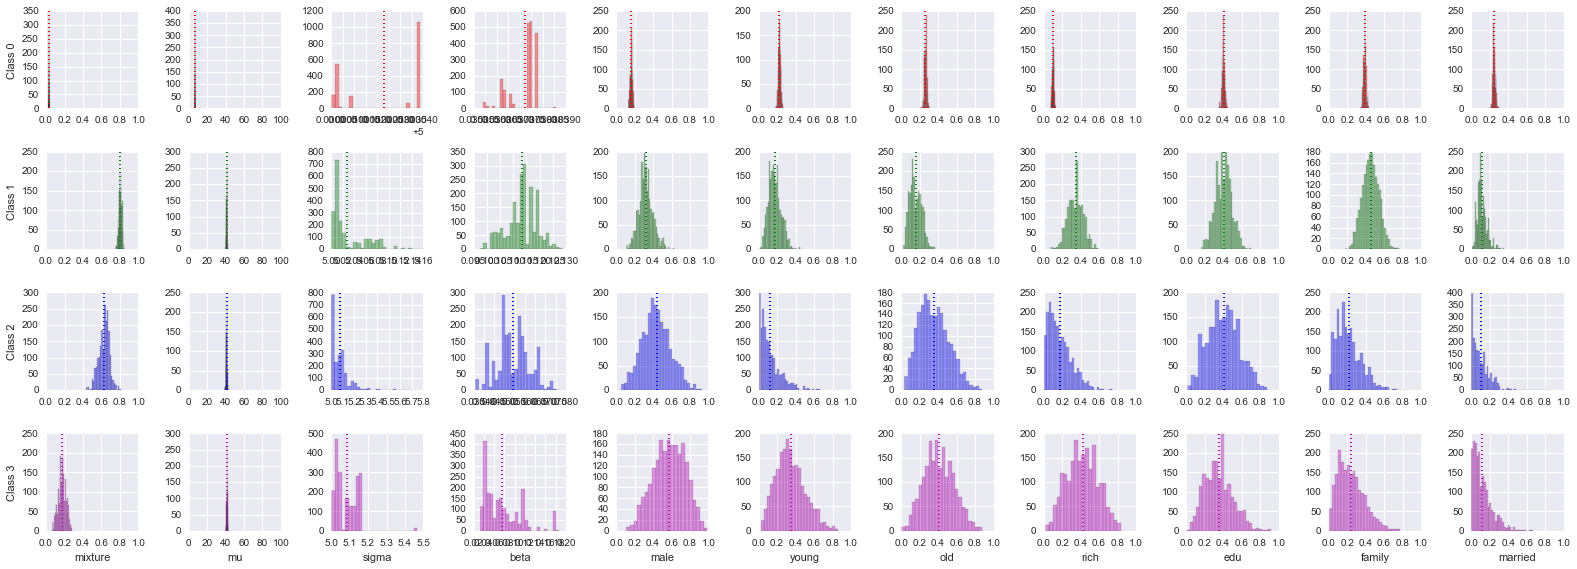

In [18]:
colors = ['r', 'g', 'b', 'm', 'y', 'c']

pl.figure(figsize=(6, 6))

klass_trace = mcmc.trace("klass_prior").gettrace(burn=1000, thin=2)[:].reshape(-1, n_classes)

for klass in xrange(n_classes):
    sns.distplot(klass_trace[:, klass], kde=False, color=colors[klass])    
    print "Cluster %d, mean %.2f" % (klass, klass_trace[:, klass].mean())    
pl.title("Class priors")
pl.xlim(0, 1)
pl.show()

n_features = n_interests + 1 + 1 + 1 + 1
pl.figure(figsize=(n_features * 2, n_classes * 2))
for klass in xrange(n_classes):   
    
    # mixture
    pl.subplot(n_classes, n_features, klass * n_features + 1)
    mix_prior_trace = mcmc.trace("mixture_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(mix_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(mix_prior_trace.mean(), ls=':', lw=2, color=colors[klass])
    pl.xlim(0, 1)    
    
    pl.ylabel("Class %d" % klass)    
    if klass == (n_classes - 1):
        pl.xlabel("mixture")
    
    # mu
    pl.subplot(n_classes, n_features, klass * n_features + 2)
    mu_prior_trace = mcmc.trace("mu_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(mu_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(mu_prior_trace.mean(), ls=':', lw=2, color=colors[klass])
    pl.xlim(0, 100)
    
    if klass == (n_classes - 1):
        pl.xlabel("mu")
    
    # sigma
    pl.subplot(n_classes, n_features, klass * n_features + 3)
    sigma_prior_trace = mcmc.trace("sigma_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(sigma_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(sigma_prior_trace.mean(), ls=':', lw=2, color=colors[klass])    
    
    if klass == (n_classes - 1):
        pl.xlabel("sigma")
    
    # beta
    pl.subplot(n_classes, n_features, klass * n_features + 4)
    beta_prior_trace = mcmc.trace("beta_prior_%d" % klass).gettrace(burn=1000, thin=2)[:]    
    sns.distplot(beta_prior_trace, kde=False, color=colors[klass], bins=25)
    pl.axvline(beta_prior_trace.mean(), ls=':', lw=2, color=colors[klass])

    if klass == (n_classes - 1):
        pl.xlabel("beta")
    
    for inter in xrange(n_interests):        
        int_prior_trace = mcmc.trace("interest_prior_%d_%d" % (inter, klass)).gettrace(burn=1000, thin=2)[:]
        pl.subplot(n_classes, n_features, klass * n_features + inter + 5)
        pl.axvline(int_prior_trace.mean(), ls=':', lw=2, color=colors[klass])
        sns.distplot(int_prior_trace, kde=False, color=colors[klass])
        pl.xlim(0, 1)
        if klass == (n_classes - 1):
            pl.xlabel(interests[inter])
    
pl.tight_layout()
pl.show()

Class=0 [ mixture=0.030, mu=7.269, sigma=5.002, beta=0.037]
Class=1 [ mixture=0.804, mu=41.276, sigma=5.028, beta=0.113]
Class=2 [ mixture=0.629, mu=41.129, sigma=5.073, beta=0.054]
Class=3 [ mixture=0.173, mu=41.704, sigma=5.083, beta=0.076]


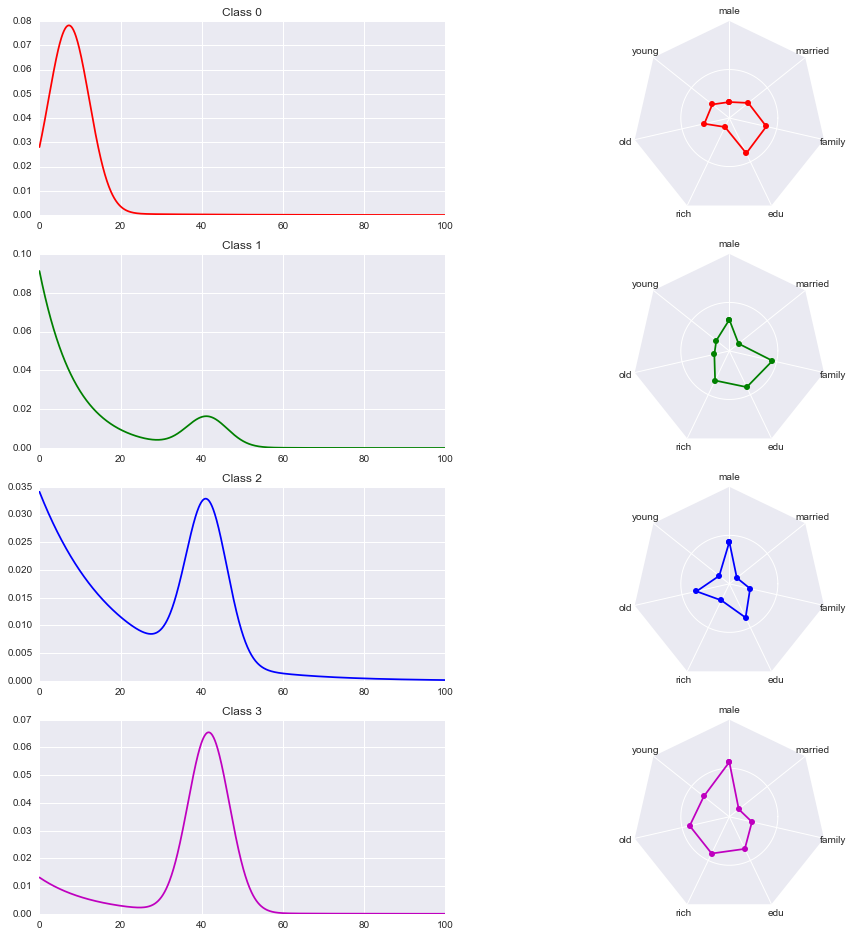

In [19]:
from radar import _radar_factory
import matplotlib.pyplot as pl

theta = _radar_factory(n_interests)

fig = pl.figure(figsize=(16, n_classes * 4))
for klass in xrange(n_classes):
    p_mix = mcmc.trace("mixture_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    mu = mcmc.trace("mu_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    sigma = mcmc.trace("sigma_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    beta = mcmc.trace("beta_prior_%d" % klass).gettrace(burn=1000, thin=2)[:].mean()
    
    print "Class=%d [ mixture=%.3f, mu=%.3f, sigma=%.3f, beta=%.3f]" % (klass, p_mix, mu, sigma, beta) 
    
    pl.subplot(n_classes, 2, klass * 2 + 1)
    x = np.linspace(0, 100, 1000)
    y = p_mix * ss.expon.pdf(x, 0, 1/beta) + (1 - p_mix) * ss.norm.pdf(x, mu, sigma)
    pl.plot(x, y, color=colors[klass])
    pl.xlim(0, 100)
    pl.title("Class %d" % klass)    
    
    ax = pl.gcf().add_subplot(n_classes, 2, klass * 2 + 2, projection='radar')
    ints = [mcmc.trace("interest_prior_%d_%d" % (i, klass))[:].mean() for i in xrange(n_interests)]           
    ax.plot(theta, ints, 'o-', color=colors[klass], markersize=6)
    ax.set_varlabels(interests)
    pl.ylim(0, 1)
    pl.yticks([0.5], [])
    
pl.show()